# Step 0

* Read the h5 file containing the scan data.
* Make sure the scan went as expected.
* Process the camera images.
    * Crop
    * Threshold
    * Downscale
* Create a new h5 file with separate scalar (0D), waveform (1D), and image (2D) data sets. The new file name is "prepoc-" + the original file name.
* Save useful information to pass to future notebooks; e.g., slit limits/correlations.

In [1]:
import sys
import os
from os.path import join
from datetime import datetime
import importlib
from pprint import pprint
import json
import numpy as np
import pandas as pd
import h5py
import skimage
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from ipywidgets import interactive
from matplotlib import pyplot as plt
from matplotlib import patches
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['grid'] = False

## Load data

In [3]:
datadir = '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2022-04-29'
filenames = os.listdir(datadir)
filenames

['220429190854-scan-xxpy-image-ypdE.png',
 '220429190854-scan-xxpy-image-ypdE.csv',
 '220429190854-scan-xxpy-image-ypdE.html',
 '220429190854-scan-xxpy-image-ypdE.txt',
 '220429190854-scan-xxpy-image-ypdE.h5',
 'preproc-220429190854-scan-xxpy-image-ypdE.h5',
 'images.h5']

In [4]:
filename = '220429190854-scan-xxpy-image-ypdE'
file = h5py.File(join(datadir, filename + '.h5'), 'r')
print(list(file))

['config', 'log', 'scandata']


In [5]:
if 'config' in file:
    config = file['config']
    print(f"'config', {type(config)}")
    for key in config:
        print(f"  '{key}', {type(config[key])}")
        for name in config[key].dtype.names:
            print(f'    {name}: {config[key][name]}')
    # Make dictionary of metadata
    metadata = dict()
    for name in config['metadata'].dtype.names:
        metadata[name] = config['metadata'][name]
else:
    # Older measurement; metadata is in json file.
    metadata = json.load(open(join(datadir, filename + '-metadata.json'), 'r'))
    _metadata = dict()
    for _dict in metadata.values():
        for key, value in _dict.items():
            _metadata[key] = value
    metadata = _metadata
    pprint(metadata)

'config', <class 'h5py._hl.group.Group'>
  'environment', <class 'h5py._hl.dataset.Dataset'>
    timestamp: [1.65127373e+09]
    user: [b'46h']
    host: [b'btf-diag-app1.ics.sns.gov']
    cmd_line: [b'scan3d/scan-xxpy-image-ypdE.py']
    work_dir: [b'/home/46h/se-template']
  'metadata', <class 'h5py._hl.dataset.Dataset'>
    timestamp: [1.65127375e+09]
    Test_LLRF:FCM_RFQ1:CtlAmpSet: [0.63]
    RFTF_TM:Gate_BeamOn:RR: [5.]
    BTF_MEBT_Mag:PS_QH01:I_Set: [157.94]
    BTF_MEBT_Mag:PS_QV02:I_Set: [280.06]
    BTF_MEBT_Mag:PS_QH03:I_Set: [6.75]
    BTF_MEBT_Mag:PS_QV04:I_Set: [-3.75]
    BTF_MEBT_Mag:PS_QH05:I_Set: [0.]
    BTF_MEBT_Mag:PS_QV06:I_Set: [-0.]
    BTF_MEBT_Mag:PS_QV07:I_Set: [-3.1]
    BTF_MEBT_Mag:PS_QH08:I_Set: [4.1]
    BTF_MEBT_Mag:PS_QV09:I_Set: [-1.85000002]
    BTF_MEBT_Mag:PS_QV10:I_Set: [-1.9]
    BTF_MEBT_Mag:PS_QH11:I_Set: [7.2]
    BTF_MEBT_Mag:PS_QV12:I_Set: [-6.55]
    BTF_MEBT_Mag:PS_QH13:I_Set: [6.00035858]
    BTF_MEBT_Mag:PS_QH33:I_Set: [5.1]
    BTF_ME

In [6]:
if 'log' in file:
    log = file['log']
    print(f"'log', {type(log)}")
    for item in log.dtype.fields.items():
        print('  ', item)

    print('\nErrors and warnings:')
    for i in range(log.size):
        if not(log[i, 'level'] == 'INFO'.encode('utf')):
            timestr = datetime.fromtimestamp(log[i, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
            print(f"{timestr} {log[i, 'message']}")

'log', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('level', (dtype('S15'), 8))
   ('source', (dtype('S20'), 23))
   ('message', (dtype('S512'), 43))

Errors and warnings:
04/29/2022, 19:54:49 b'Step/sweep 253 invalid due to lack of data, will re-try in 1 seconds.'
04/29/2022, 19:55:06 b'Step/sweep 253 invalid due to lack of data, will re-try in 2 seconds.'
04/29/2022, 19:55:24 b'Step/sweep 253 invalid due to lack of data, will re-try in 4 seconds.'
04/29/2022, 19:55:44 b'Step/sweep 253 invalid due to lack of data, will re-try in 8 seconds.'
04/29/2022, 19:56:07 b'Step/sweep 253 invalid due to lack of data, will re-try in 16 seconds.'
04/29/2022, 19:56:39 b'Step/sweep 253 invalid due to lack of data, will re-try in 32 seconds.'
04/29/2022, 19:57:27 b'Step/sweep 253 invalid due to lack of data, will re-try in 64 seconds.'
04/29/2022, 19:58:47 b'Step/sweep 253 invalid due to lack of data, will re-try in 128 seconds.'
04/29/2022, 20:01:11 b'Step/sweep 253 inv

In [7]:
data = file['scandata']

print(f"'scandata', {type(data)}")
for item in data.dtype.fields.items():
    print('  ', item)
print(f"nbytes = {data.nbytes:.3e}")

'scandata', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('iteration', (dtype('int64'), 8))
   ('cam34_Image', (dtype(('<i4', (313344,))), 16))
   ('cam34_ProfileY', (dtype(('<f4', (512,))), 1253392))
   ('cam34_ProfileX', (dtype(('<f4', (612,))), 1255440))
   ('cam34_Saturation', (dtype('<f8'), 1257888))
   ('cam34_Integral', (dtype('<f8'), 1257896))
   ('bcm04', (dtype('<f8'), 1257904))
   ('y_PositionSync', (dtype('<f8'), 1257912))
   ('xp_PositionSync', (dtype('<f8'), 1257920))
   ('x_PositionSync', (dtype('<f8'), 1257928))
nbytes = 5.805e+10


In [8]:
acts = ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync']

In [9]:
info = dict()  # to pass info between notebooks
info['acts'] = acts
info['datadir'] = datadir
info['filename'] = filename

## Scan overview 

Input the min/max slit coordinates, shearing matrix, and boundary (box, ellipsoid) here. These will be used in subsequent notebooks.

In [10]:
# Slit ranges, steps, and limits
ndim = 3
variables = {
    'y1': {
        'pvname': 'ITSF_Diag:Slit_HZ34a',
        'center': 6.5,
        'distance': 14.5,
        'steps': 32,
        'min': -50.0,
        'max': +50.0,
    },   
    'x2': {
        'pvname': 'ITSF_Diag:Slit_VT34b',
        'center': 15.0,
        'distance': 24.0,
        'steps': 32,
        'min': -50.0,
        'max': +50.0,
    },
    'x1': {
        'pvname': 'ITSF_Diag:Slit_VT34a',
        'center': 21.0,
        'distance': 17.5,
        'steps': 32,
        'min': -50.0, 
        'max': +50.0,
    }
}
keys = list(variables)

# An affine transformation M is applied to the regular grid defined above.
M = np.identity(ndim)
M[keys.index('x2'), keys.index('x1')] = 1.9

# Save to info dict
info['variables'] = variables
info['M'] = M
info['ndim'] = ndim

### Data collection frequency

In [11]:
duration = data[-1, 'timestamp'] - data[0, 'timestamp']
iteration_duration = duration / data[-1, 'iteration']
points_per_iteration = len(data) / data[-1, 'iteration']
print(f'{len(data)} points recorded over {duration:.1f} seconds ({(duration / 3600.0):.1f} hours)')
print(f"Number of iterations: {data[-1, 'iteration']}")
print(f'Effective rep rate: {(len(data) / duration):.2f} Hz')
print(f'Time per iteration: {iteration_duration:.2f} seconds')
print(f'Points per iteration: {points_per_iteration:.2f}')

46146 points recorded over 15885.6 seconds (4.4 hours)
Number of iterations: 1089
Effective rep rate: 2.90 Hz
Time per iteration: 14.59 seconds
Points per iteration: 42.37


Look for long pauses during data collection.

reprate = 5.00 Hz
Pauses longer than 30 seconds:
[1191.90364909 1802.96420908 1184.74736118]
Most pauses are 2.40 seconds


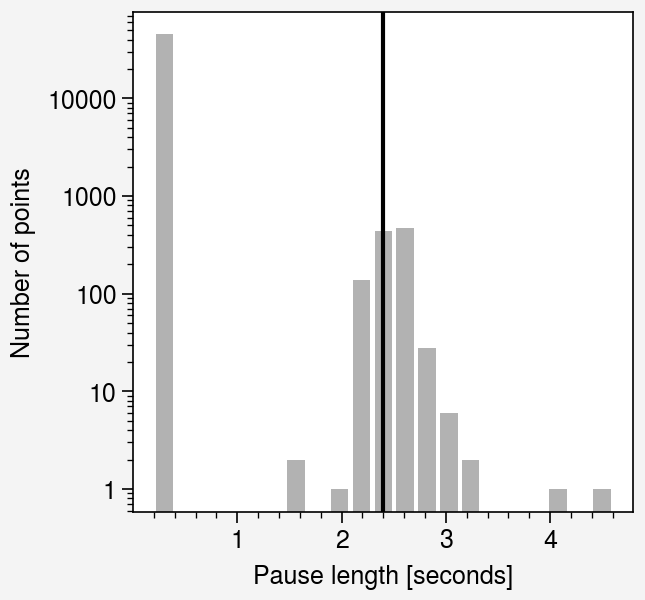

In [12]:
dt = np.diff(data[:, 'timestamp'])
rep_rate = 1.0 / np.median(dt)
print(f'reprate = {rep_rate:.2f} Hz')

print('Pauses longer than 30 seconds:')
long_pause = 30.0
print(dt[dt > long_pause])
dt[dt > long_pause] = 0.2

hist, bins = np.histogram(dt, bins=21)
idx_bins = np.digitize(dt, bins)
idx_pause, = np.where(idx_bins > 1)
median_pause = np.median(dt[idx_pause])
print(f'Most pauses are {median_pause:.2f} seconds')

fig, ax = pplt.subplots()
ax.bar(0.5 * (bins[1:] + bins[:-1]), hist, color='black', alpha=0.3)
ax.axvline(median_pause, color='black')
ax.format(xlabel='Pause length [seconds]', ylabel='Number of points', yscale='log')
plt.savefig('_output/pauses.png')

### BCM current

In [13]:
bcm = 'bcm04'
bcm_limit = 20.0  # [mA]
bcm_data = np.copy(data[bcm])

idx = np.arange(len(data))
idx_mask, = np.where(data[bcm] > -bcm_limit)
idx_valid, = np.where(~np.isin(idx, idx_mask))

print(f'Average BCM current (before masking) = {np.mean(bcm_data):.3f} +- {np.std(bcm_data):.3f} [mA]')
for i in idx_mask:
    print(f'Point {i} masked due to {bcm} current < {bcm_limit:.3f} [mA]')
print(f'Average BCM current (after masking) = {np.mean(bcm_data[idx_valid]):.3f} +- {np.std(bcm_data[idx_valid]):.3f} [mA]')

Average BCM current (before masking) = -29.828 +- 0.223 [mA]
Point 41812 masked due to bcm04 current < 20.000 [mA]
Point 41813 masked due to bcm04 current < 20.000 [mA]
Average BCM current (after masking) = -29.829 +- 0.103 [mA]


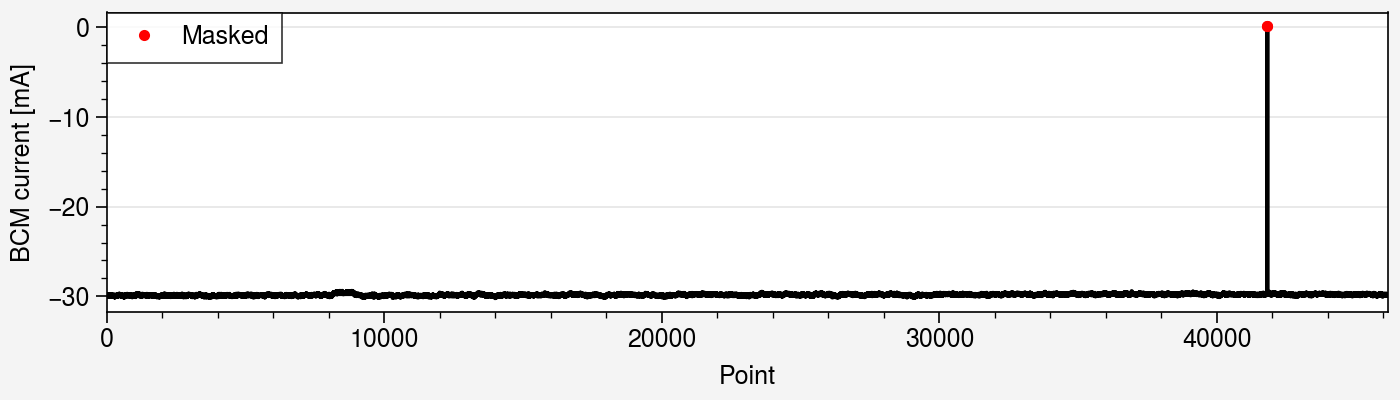

In [14]:
fig, ax = pplt.subplots(figsize=(7.0, 2.0))
ax.plot(bcm_data[idx], color='black')
ax.plot(idx_mask, bcm_data[idx_mask], color='red', lw=0, marker='.', label='Masked')
ax.format(xlabel='Point', ylabel='BCM current [mA]', ygrid=True)
ax.legend(loc='upper left')
plt.savefig('_output/bcm_mask.png')
plt.show()

### Slit positions 

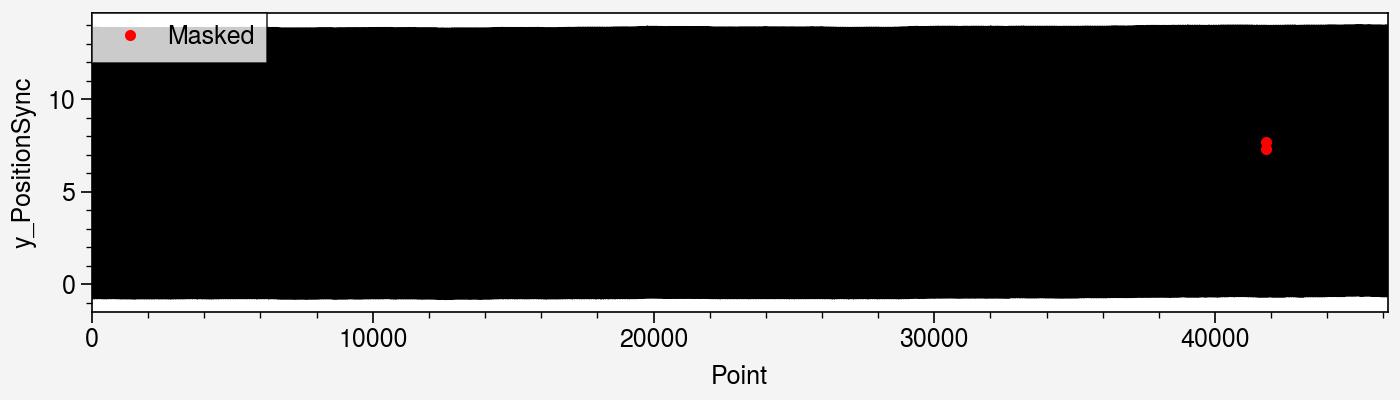

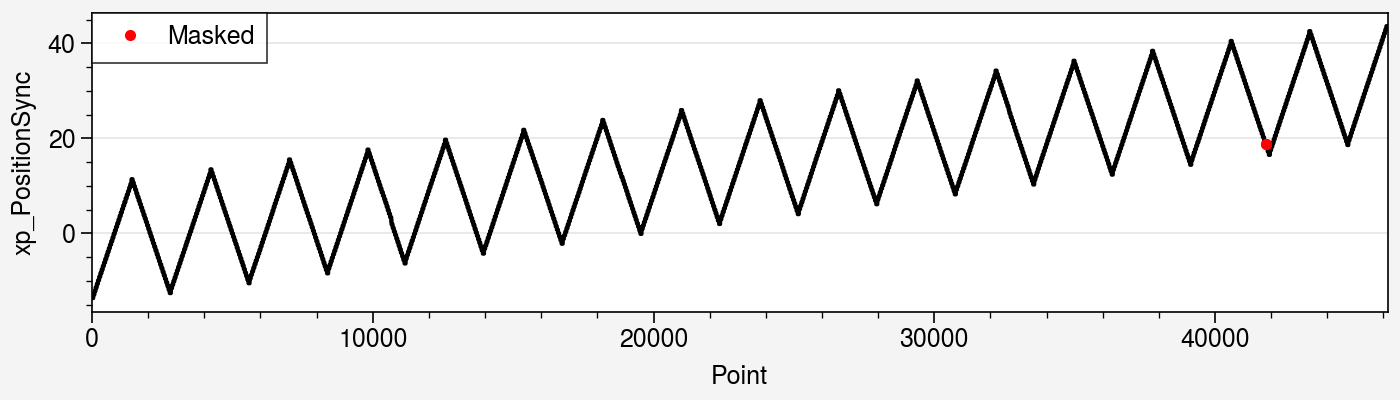

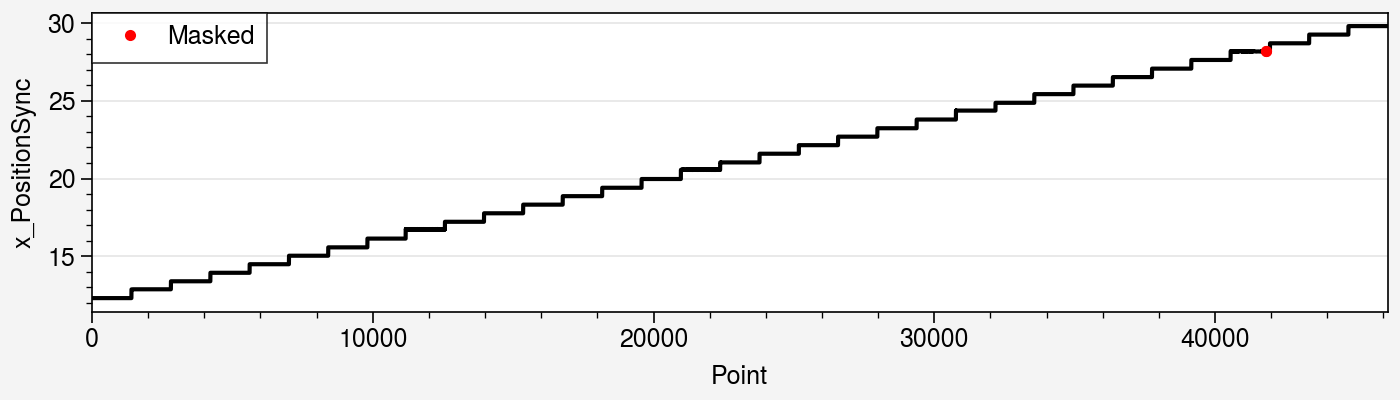

In [15]:
for act in acts:
    fig, ax = pplt.subplots(figsize=(7.0, 2.0))
    ax.plot(idx, data[idx, act], color='black')
    ax.plot(idx_mask, data[idx_mask, act], color='red', lw=0, marker='.', label='Masked')
    ax.format(xlabel='Point', ylabel=act, ygrid=True)
    ax.legend(loc='upper left')
    plt.savefig('_output/acts_mask.png')
    plt.show()

### Measured signal

Get camera name and settings.

In [16]:
# Find camera name.
cam = None
for name in data.dtype.names:
    if 'cam' in name.lower():
        cam = name.split('_')[0]
        
## Find camera zoom. 
zoom = 1.0
for key in metadata:
    if 'Magn' in key:
        zoom = 1.0 / float(metadata[key])
        print(f'Found zoom={zoom} in metadata. Please verify!')
        
## The above code doesn't always work; is 'Magn' not equivalent to zoom?
## If it gives the wrong zoom, type it manually here.
zoom = 0.5
        
# Load camera settings. 
cam_settings = ip.CameraSettings(cam)
cam_settings.set_zoom(zoom)

## (Note that the image shape may be different if 
## cropping was done on the EDM screen. If this was done, an error will
## occur later in this notebook when trying to reshape the image array,
## and the correct image shape will need to be set here manually.)
# cam_settings.shape = (258, 346)

# Save info.
info['cam'] = cam_settings.name
info['cam_zoom'] = cam_settings.zoom
info['cam_pix2mm_y'] = info['cam_pix2mm_x'] = cam_settings.pix2mm
info['cam_shape'] = cam_settings.shape

print(f"cam = '{cam}'")
print(f'zoom = {zoom}')
print(f'pix2mm = {cam_settings.pix2mm} (zoom = {zoom})')
print(f'image shape = {cam_settings.shape}')

Found zoom=0.5 in metadata. Please verify!
cam = 'cam34'
zoom = 0.5
pix2mm = 0.1 (zoom = 0.5)
image shape = (512, 612)


Define `signal` as the camera integral normalized to the range [0, 1]. 

In [17]:
signal = data[:, cam + '_Integral'].copy()
saturation = data[:, cam + '_Saturation'].copy()

signal = (signal - np.min(signal)) / np.max(signal)

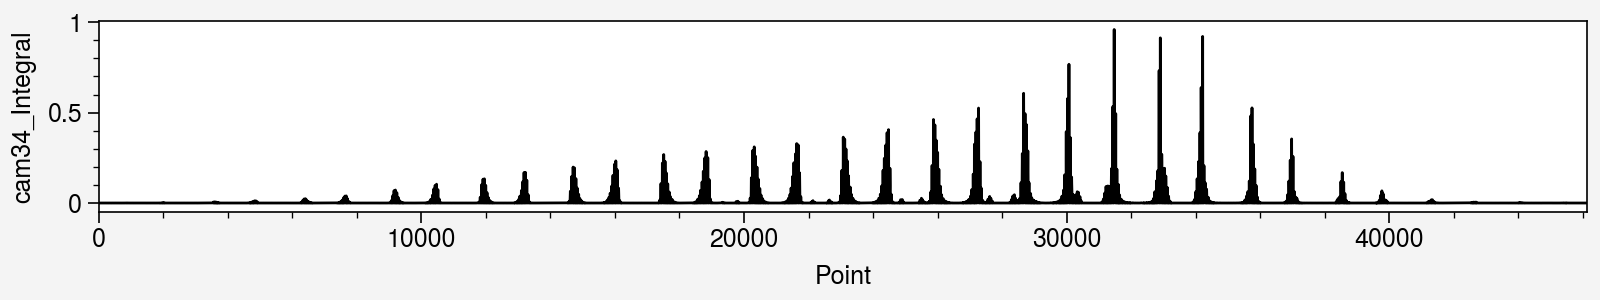

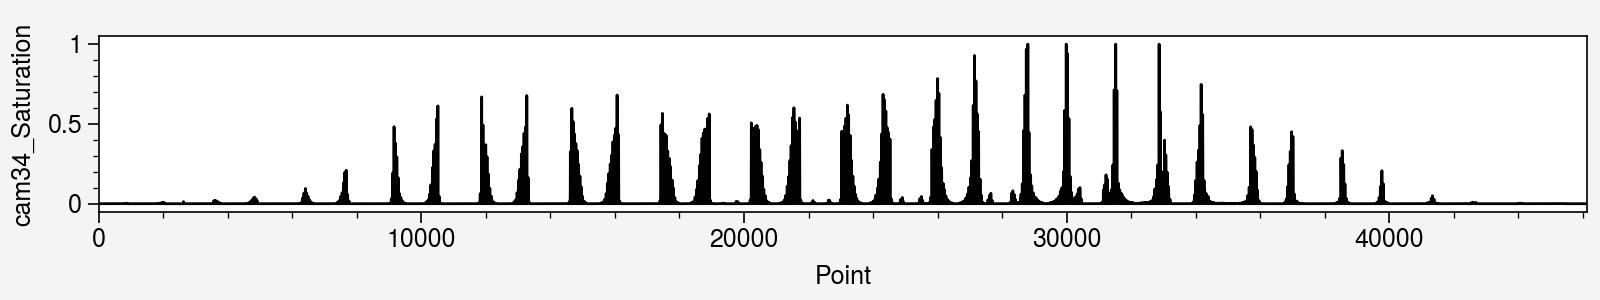

In [18]:
fig, ax = pplt.subplots(figsize=(8.0, 1.5))
ax.plot(signal, color='black', lw=1)
ax.format(xlabel='Point', ylabel=f'{cam}_Integral')

fig, ax = pplt.subplots(figsize=(8.0, 1.5))
ax.plot(saturation, color='black', lw=1)
ax.format(xlabel='Point', ylabel=f'{cam}_Saturation')

### Iteration numbers

In [19]:
# fig, ax = pplt.subplots(figsize=(7, 2))
# ax.plot(data['iteration'], color='black')
# ax.format(xlabel='Step', ylabel='Iteration #')

## Image processing

Use the images with the largest/smallest integral for testing image processing.

In [20]:
def get_image(i):
    """Return the reshaped image."""
    return data[i, cam + '_Image'].reshape(cam_settings.shape)

def plot_compare_images(im1, im2, **plot_kws):
    """Plot images side by side, and a second row in log scale."""
    fig, axes = pplt.subplots(ncols=2, nrows=2, figwidth=None, sharex=False, sharey=False)
    for col, im in enumerate([im1, im2]):
        for row, norm in enumerate([None, 'log']):
            mplt.plot_image(im.T / np.max(im), ax=axes[row, col], norm=norm, **plot_kws)
    return axes

In [21]:
imax = np.argmax(signal)
imin = np.argmin(signal)
im_max = get_image(imax)
im_min = get_image(imin)
print(f'Max {cam}_Integral at i = {imax}')
print(f'Min {cam}_Integral at i = {imin}')

Max cam34_Integral at i = 31474
Min cam34_Integral at i = 37896


In [22]:
print(imin in idx_valid)

True


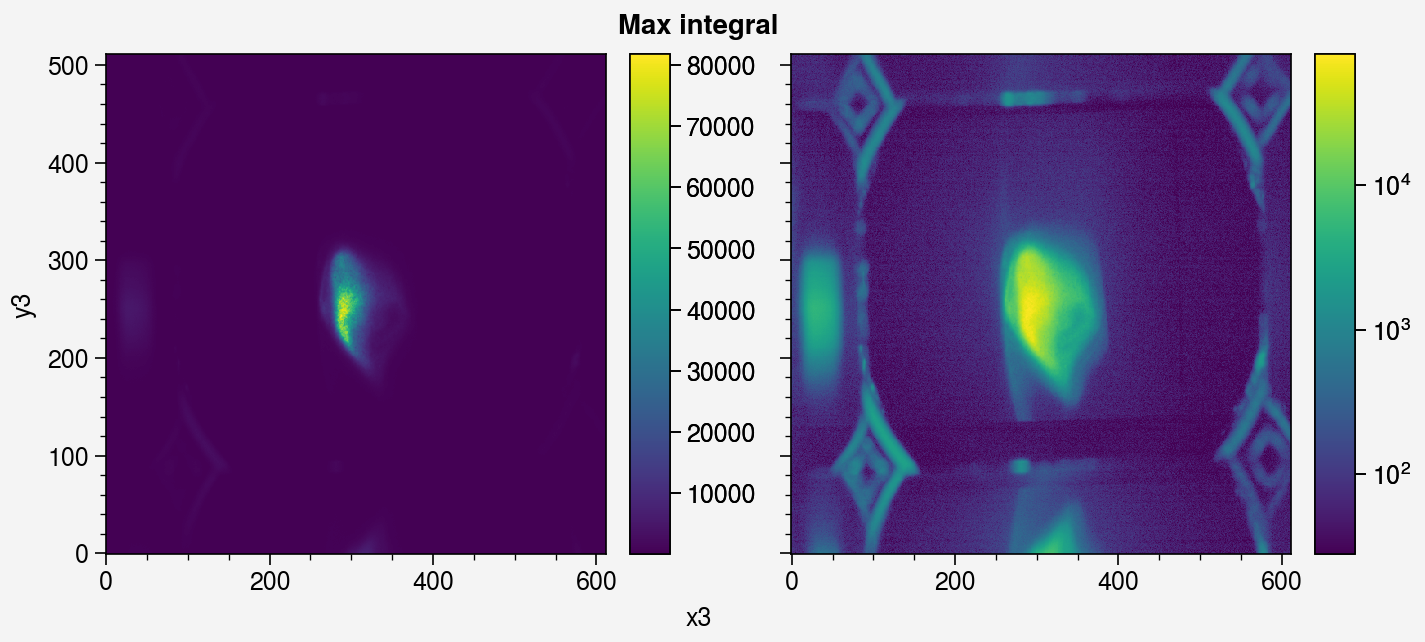

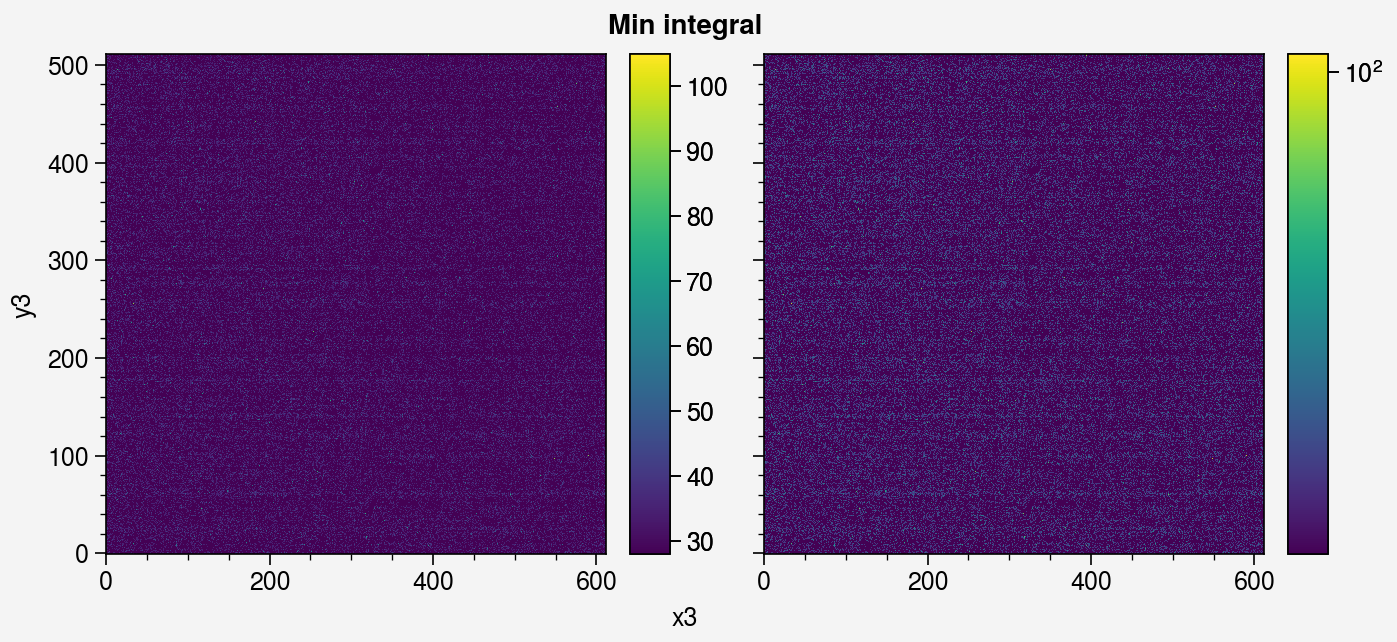

In [23]:
for im, title in zip((im_max, im_min), ('Max integral', 'Min integral')):
    fig, axes = pplt.subplots(ncols=2)
    kws = dict(colorbar=True)
    mplt.plot_image(im.T, ax=axes[0], **kws)
    mplt.plot_image(im.T, ax=axes[1], norm='log', **kws)
    axes.format(xlabel='x3', ylabel='y3', suptitle=title)
    plt.savefig(f'_output/image_{title}.png')
    plt.show()

### Crop

If the camera is zoomed out, it is necessary to crop the image to get rid of reflections. Test this on the brightest image.

In [24]:
im = im_max.copy()

print('Collecting y profiles.')
if (cam + '_ProfileY') in data.dtype.names:
    yprofs = data[cam + '_ProfileY'].copy()
else:
    yprofs = np.array([np.sum(get_image(i), axis=1) for i in trange(len(data))])
    
print('Collecting x profiles.')
if (cam + '_ProfileX') in data.dtype.names:
    xprofs = data[cam + '_ProfileX'].copy()
else:
    xprofs = np.array([np.sum(get_image(i), axis=0) for i in trange(len(data))])
    
print('Done.')

Done.


In [25]:
# Define the crop edges.
# x1, x2 = (150, 500)  # Cam34 at zoom=0.5
x1, x2 = (150 + 50, 500 - 50)  # Cam34 at zoom=0.5, crop x (2022-04-29)
# x1, x2 = (150 + 20, 500 - 80)  # Cam34 at zoom=0.5, crop x (2022-07-13)
y1, y2 = (135, 435)
image_crop_edges = dict(x1=x1, x2=x2, y1=y1, y2=y2)

def update(i, log):
    im = get_image(i)
    norm = None
    if log:
        norm = 'log'
    fig, ax = pplt.subplots()
    ax.pcolormesh(im, colorbar=True, norm=norm)
    ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, ec='red'))
    plt.show()
    
interactive(update, i=(imax-50, imax+50), log=True)

interactive(children=(IntSlider(value=31474, description='i', max=31524, min=31424), Checkbox(value=True, desc…

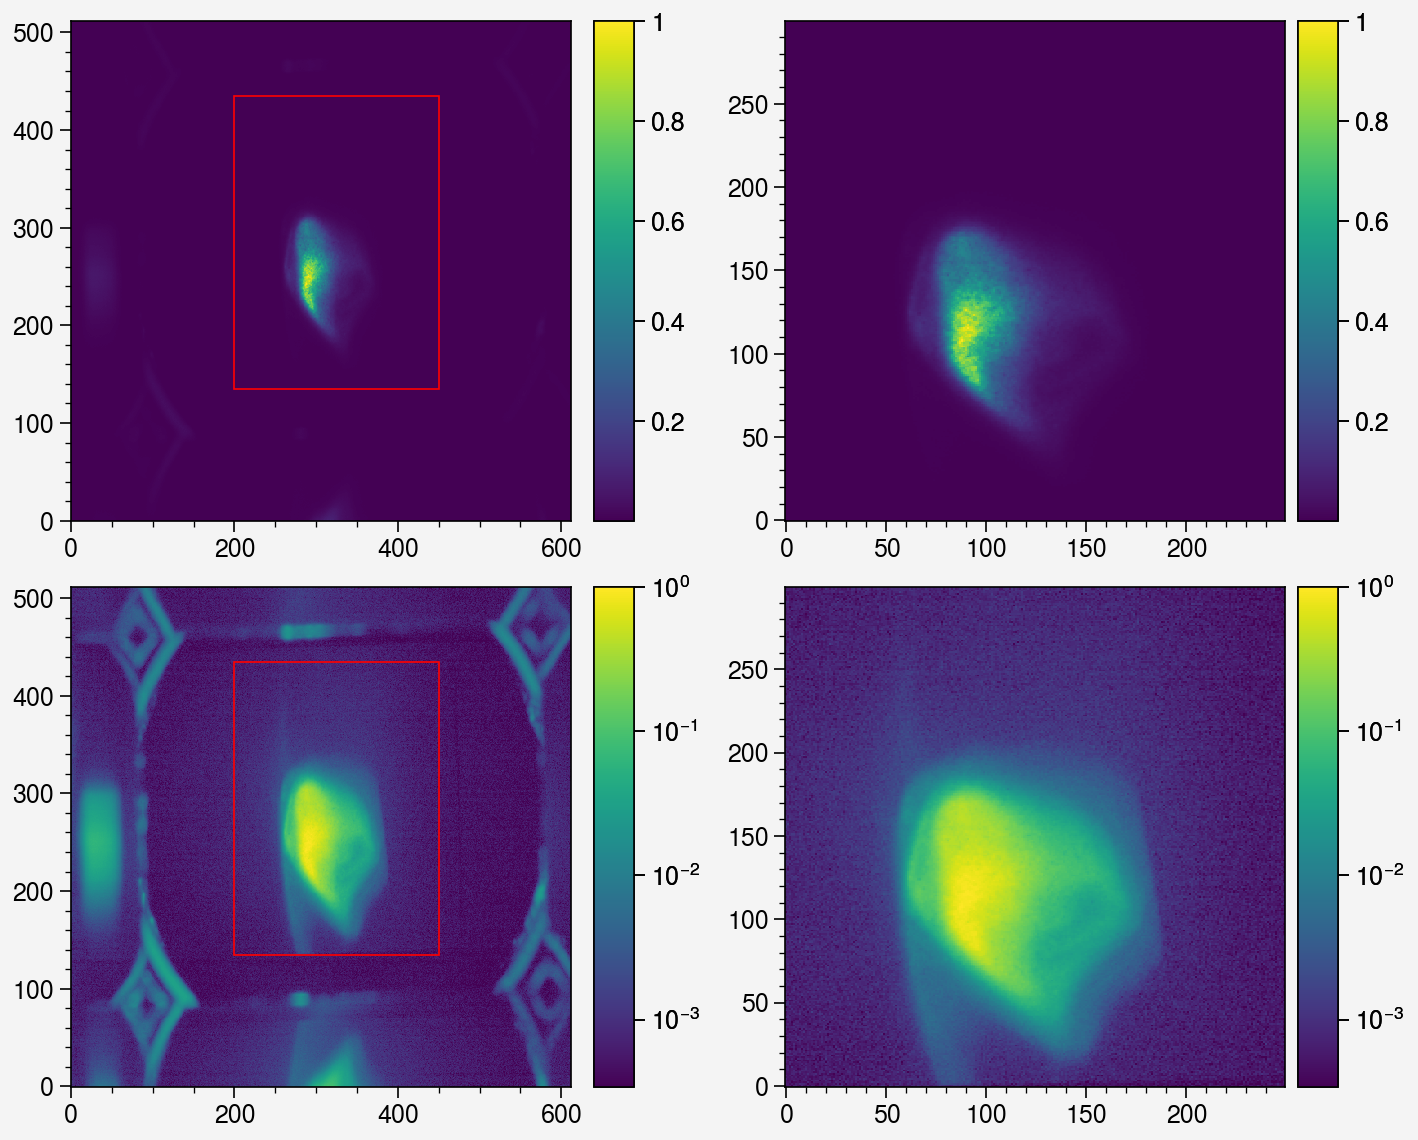

In [26]:
# Crop the image.
im1 = ip.crop(im, **image_crop_edges)

# Plot before/after.
axes = plot_compare_images(im, im1, colorbar=True)
for ax in axes[:, 0]:
    ax.add_patch(patches.Rectangle((x1, y1), im1.shape[1], im1.shape[0], fill=False, ec='red'))
plt.savefig('_output/crop.png')
plt.show()

Make sure that nothing important will be cropped in the other images.

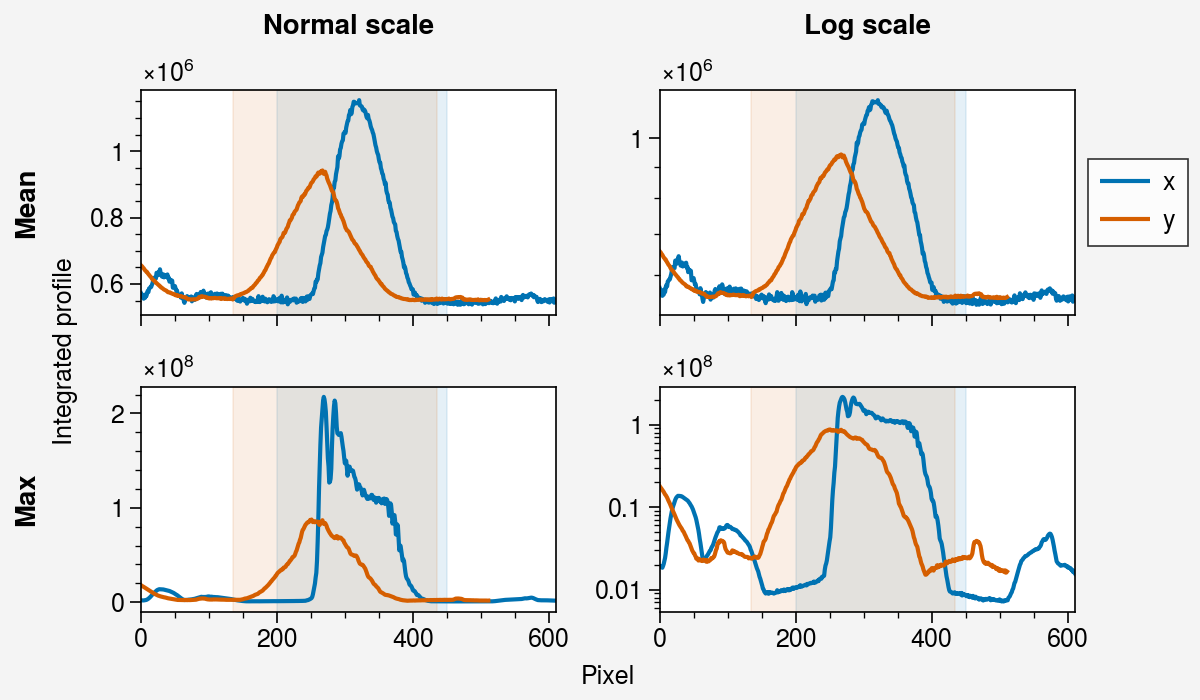

In [27]:
# Plot mean and max heights of all x/y profiles.
fig, axes = pplt.subplots(nrows=2, ncols=2, figsize=(6, 3.5), sharey=1)
for j in range(2):
    for ax, func in zip(axes[:, j], [np.mean, np.max]):
        for profs, label in zip([xprofs, yprofs], ['x', 'y']):
            ax.plot(np.arange(profs.shape[1]), func(profs, axis=0), label=label)
axes[0, 1].legend(ncols=1, loc='r')
# Plot light blue{orange} in uncropped x{y} region.
colors = pplt.Cycle('colorblind').by_key()['color']
for _x1, _x2, _xmax, c in zip([x1, y1], [x2, y2], [xprofs.shape[1], yprofs.shape[1]], colors):
    if _x2 < 0:
        _x2 += _xmax
    for ax in axes:
        ax.axvspan(_x1, _x2, color=c, alpha=0.1)
axes[:, 1].format(yscale='log')
axes.format(leftlabels=['Mean', 'Max'], toplabels=['Normal scale', 'Log scale'],
            xlabel='Pixel', ylabel='Integrated profile')
plt.savefig('_output/crop2.png')
plt.show()

In [28]:
info['image_crop_edges'] = image_crop_edges
im = im1.copy()

### Threshold

Sometimes there is a constant pixel offset in the images.

  0%|          | 0/9228 [00:00<?, ?it/s]

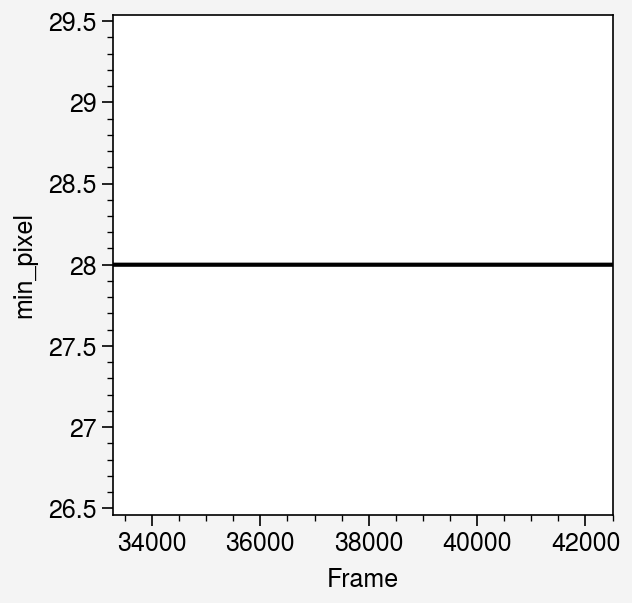

In [29]:
window = int(0.1 * len(data))
frames = np.arange(imin - window, imin + window, 1)
min_pixels = [np.min(get_image(i)) for i in tqdm(frames)]

fig, ax = pplt.subplots()
ax.plot(frames, min_pixels, color='black')
ax.format(xlabel='Frame', ylabel='min_pixel')
plt.savefig('_output/offset.png')
plt.show()

In [30]:
image_offset = np.mean(min_pixels)
info['image_offset'] = image_offset
print(image_offset)

im = im - image_offset

28.0


Select images that are obviously measuring noise — a window near `imin` — and use the maximum pixel from those images as the threshold. Tune `width_view` to view more frames; tune `width_select` to select the frames.

For selected images:
max pixel: 126
min noise: 28
mean noise: 30.493991677278007
std noise: 4.353364311987443


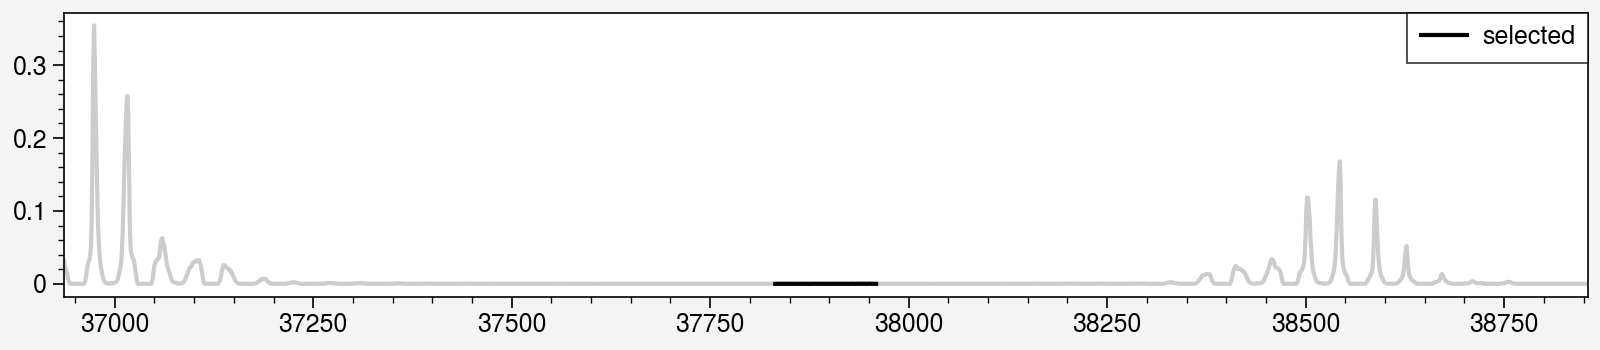

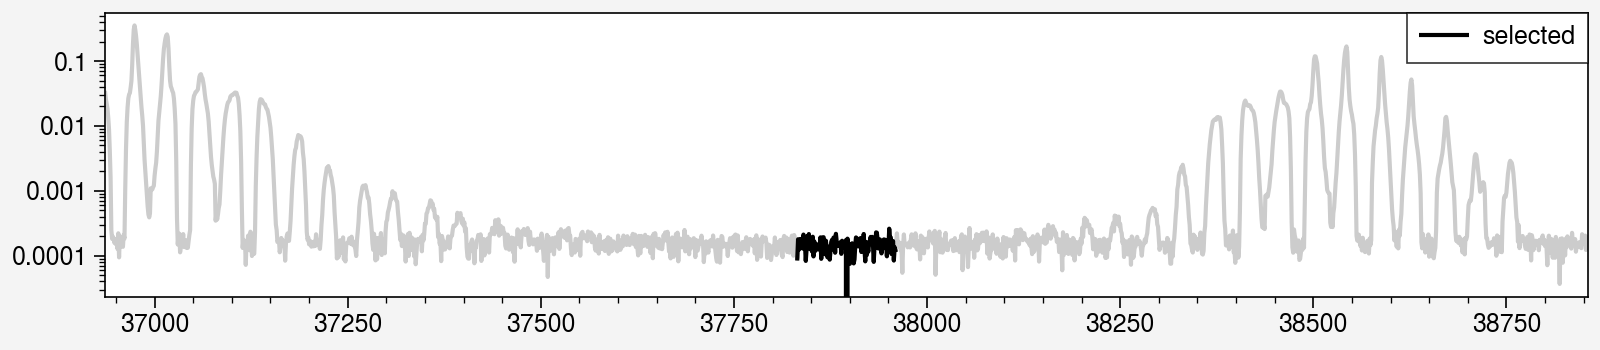

In [31]:
width_view = 30 * variables['y1']['steps']
width_calc = 2 * variables['y1']['steps']
idx_view = np.arange(imin - width_view, imin + width_view, 1)
idx_calc = np.arange(imin - width_calc, imin + width_calc, 1)

ims_noise = np.array([get_image(i) for i in idx_calc])
print('For selected images:')
print(f'max pixel: {np.max(ims_noise)}')
print(f'min noise: {np.min(ims_noise)}')
print(f'mean noise: {np.mean(ims_noise)}')
print(f'std noise: {np.std(ims_noise)}')

for yscale in [None, 'log']:
    fig, ax = pplt.subplots(figsize=(8.0, 1.75))
    ax.plot(idx_view, signal[idx_view], color='black', alpha=0.2)
    ax.plot(idx_calc, signal[idx_calc], color='black', label='selected')
    ax.legend(loc='upper right')
    ax.format(yscale=yscale)
    plt.savefig(f'_output/noise_region_{yscale}.png')
    plt.show()

View how the thresholding affects the brightest image. It may be helpful to toggle the `discrete` option in the plotting routine.

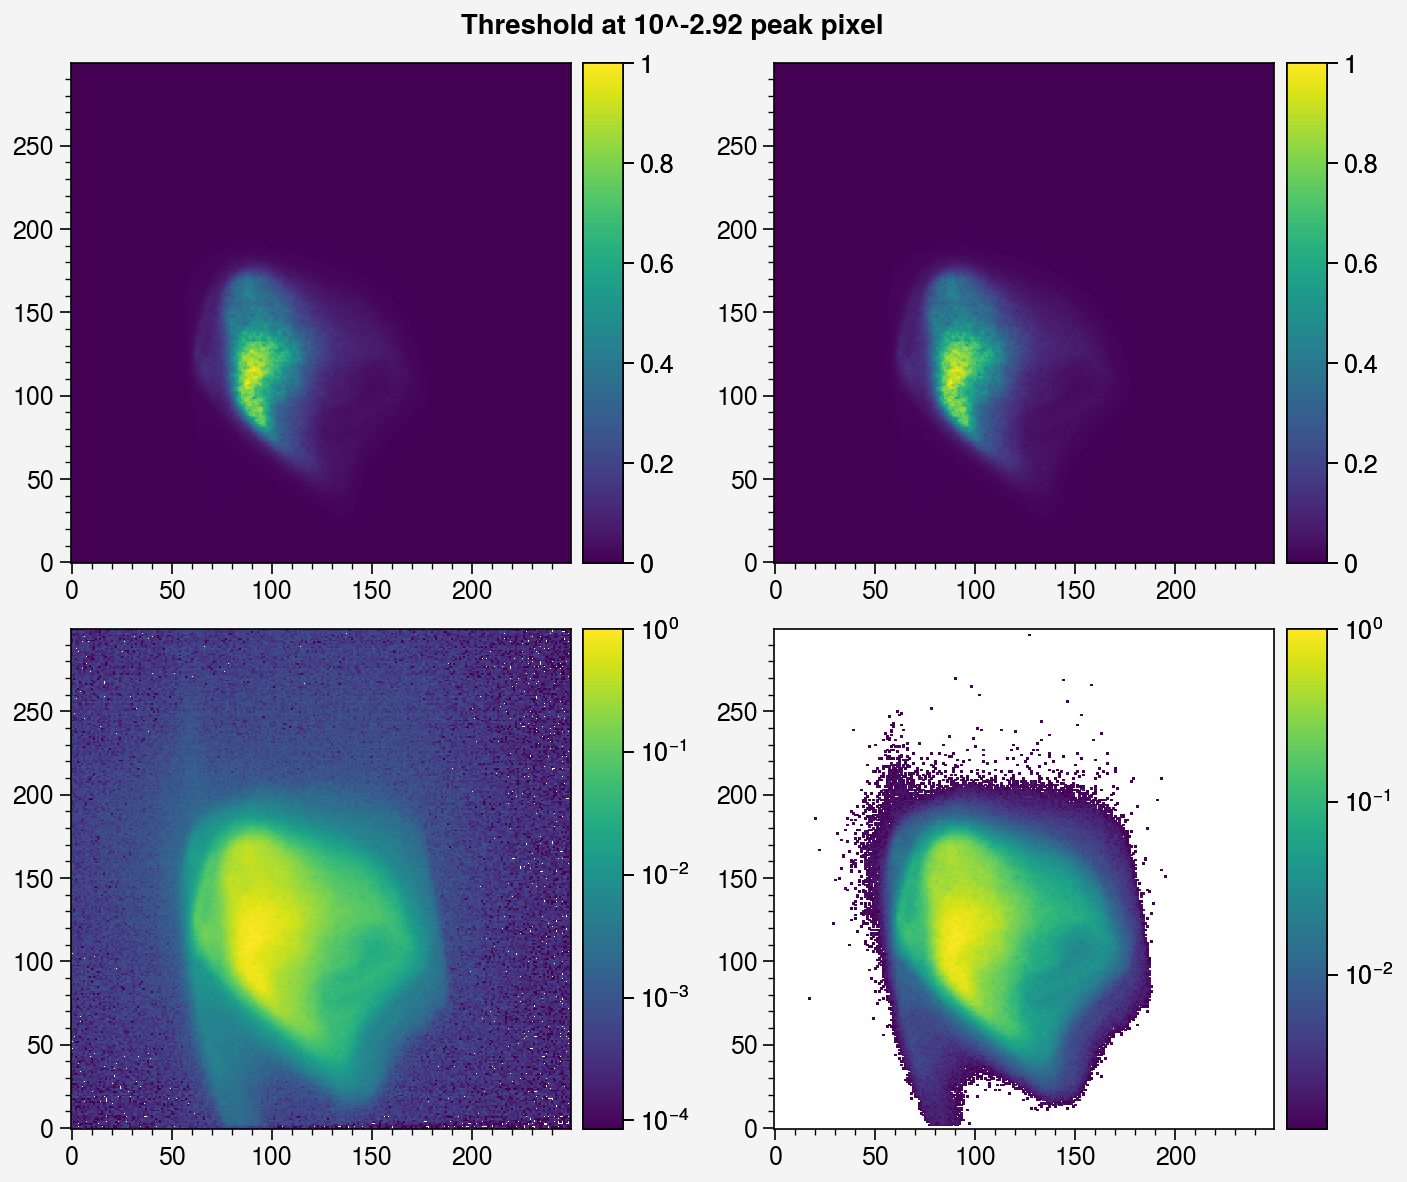

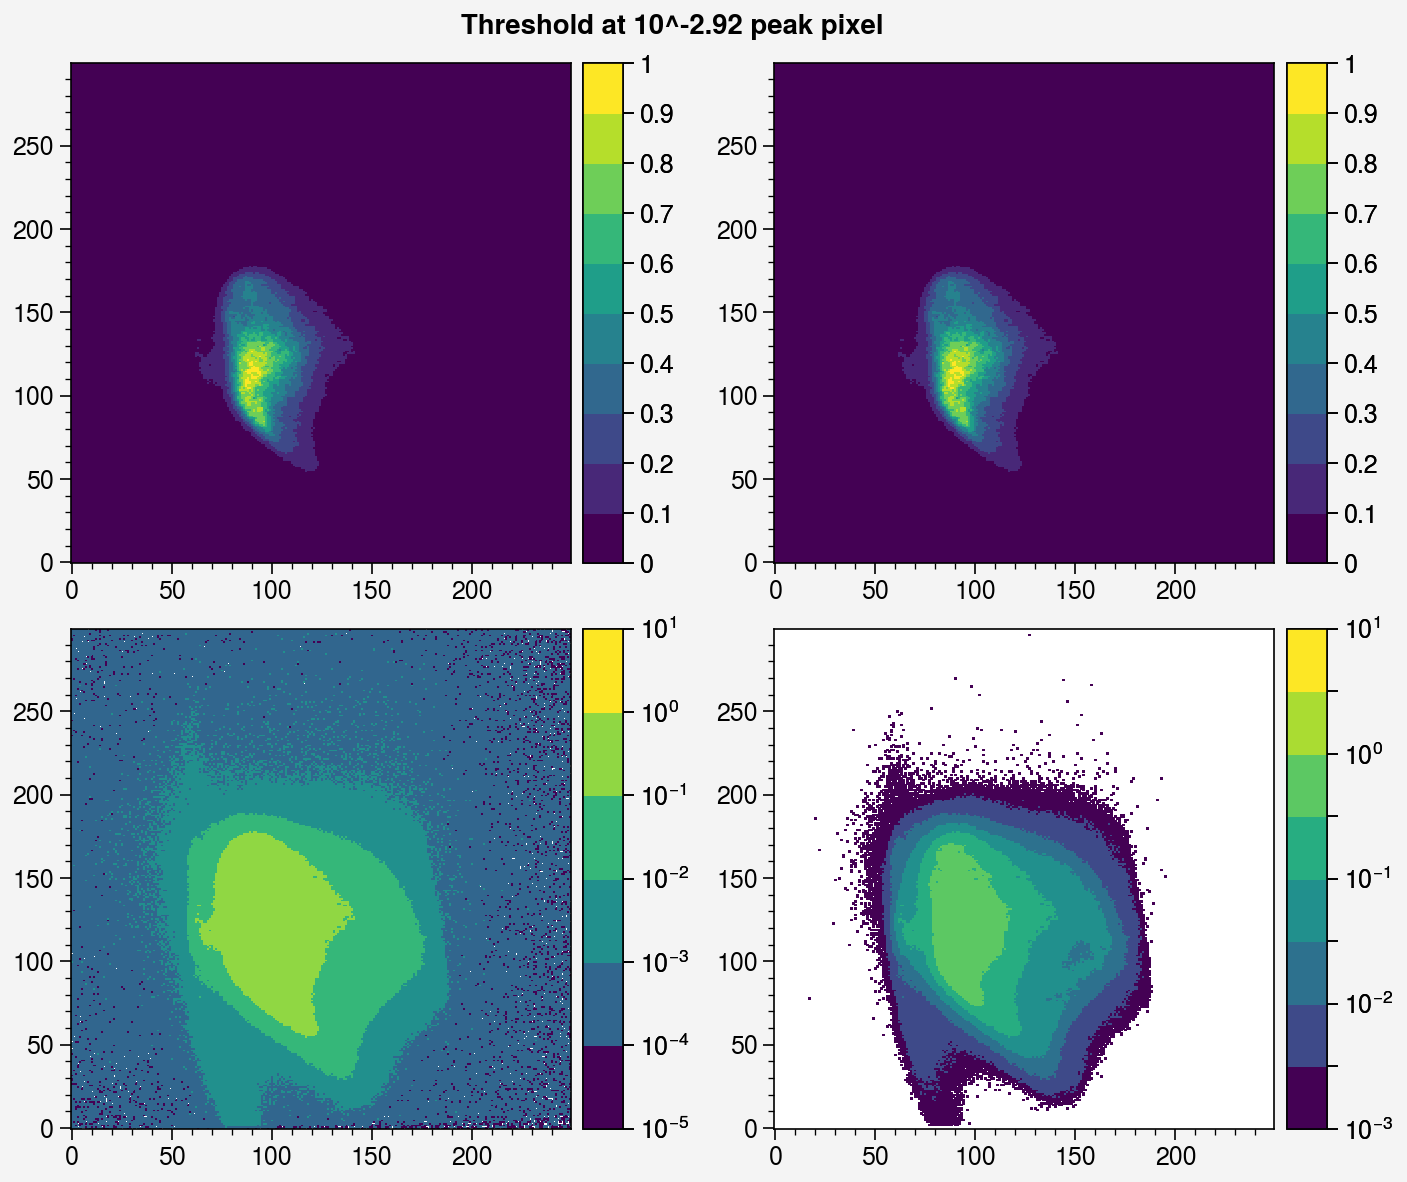

In [32]:
thresh = 1.0 * np.max(ims_noise) - image_offset
thresh_frac_peak = thresh / np.max(im)

im1 = im.copy()
im1[im1 <= thresh] = 0
info['image_thresh'] = thresh

for discrete in [False, True]:
    axes = plot_compare_images(im / np.max(im), im1 / np.max(im1), colorbar=True, discrete=discrete,
                               handle_log='mask')
    axes.format(suptitle=f'Threshold at 10^{np.log10(thresh_frac_peak):.2f} peak pixel')
    plt.savefig(f'_output/thresh_discrete{discrete}.png')
    plt.show()

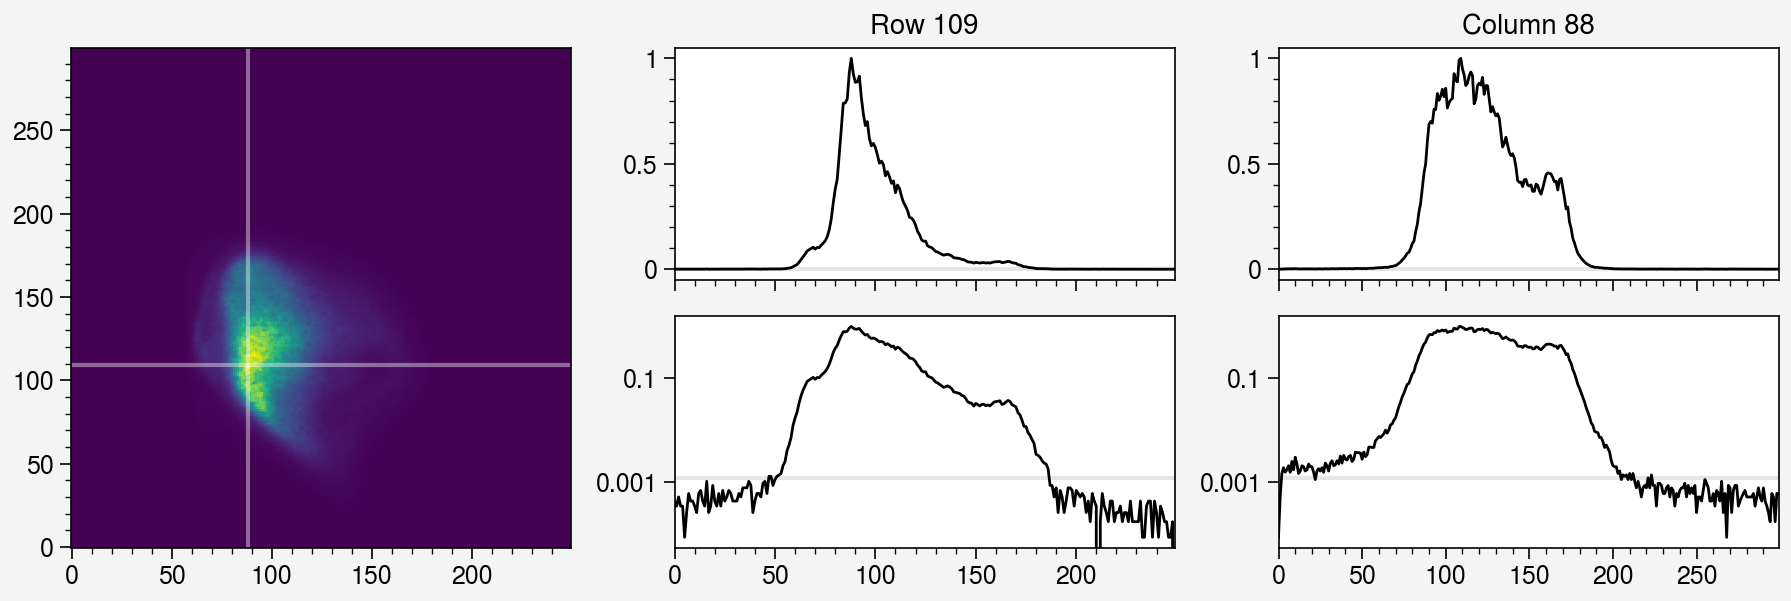

In [33]:
i, j = np.unravel_index(np.argmax(im), im.shape)
fig, axes = pplt.subplots([[1, 2, 3], [1, 4, 5]], sharey=False)
axes[0].pcolormesh(im)
kws = dict(color='white', alpha=0.4)
axes[0].axhline(i, **kws)
axes[0].axvline(j, **kws)
axes[1].set_title(f'Row {i}')
axes[2].set_title(f'Column {j}')
kws = dict(color='black', lw=1.0)
for ax in axes[:, 1]:
    ax.plot(np.arange(im.shape[1]), im[i, :] / np.max(im[i, :]), **kws)
    ax.axhline(thresh / np.max(im[i, :]), color='black', alpha=0.1)
for ax in axes[:, 2]:
    ax.plot(np.arange(im.shape[0]), im[:, j] / np.max(im[:, j]), **kws)
    ax.axhline(thresh / np.max(im[:, j]), color='black', alpha=0.1)
axes[1:, 1:].format(yscale='log')
plt.savefig('_output/thresh2.png')
plt.show()

In [34]:
def update(i, log, handle_log):
    _im = get_image(i)
    _im = ip.crop(_im, **image_crop_edges)
    _im = _im - image_offset
    _im[_im <= thresh] = 0
    norm = 'log' if log else None
    fig, ax = pplt.subplots()
    mplt.plot_image(_im.T, ax=ax, colorbar=True, norm=norm, handle_log=handle_log)
    plt.show()
    
interactive(update, i=(imax-50, imax+50), log=True, handle_log=['floor', 'mask'])

interactive(children=(IntSlider(value=31474, description='i', max=31524, min=31424), Checkbox(value=True, desc…

In [35]:
im = im1.copy()

### Downscale 

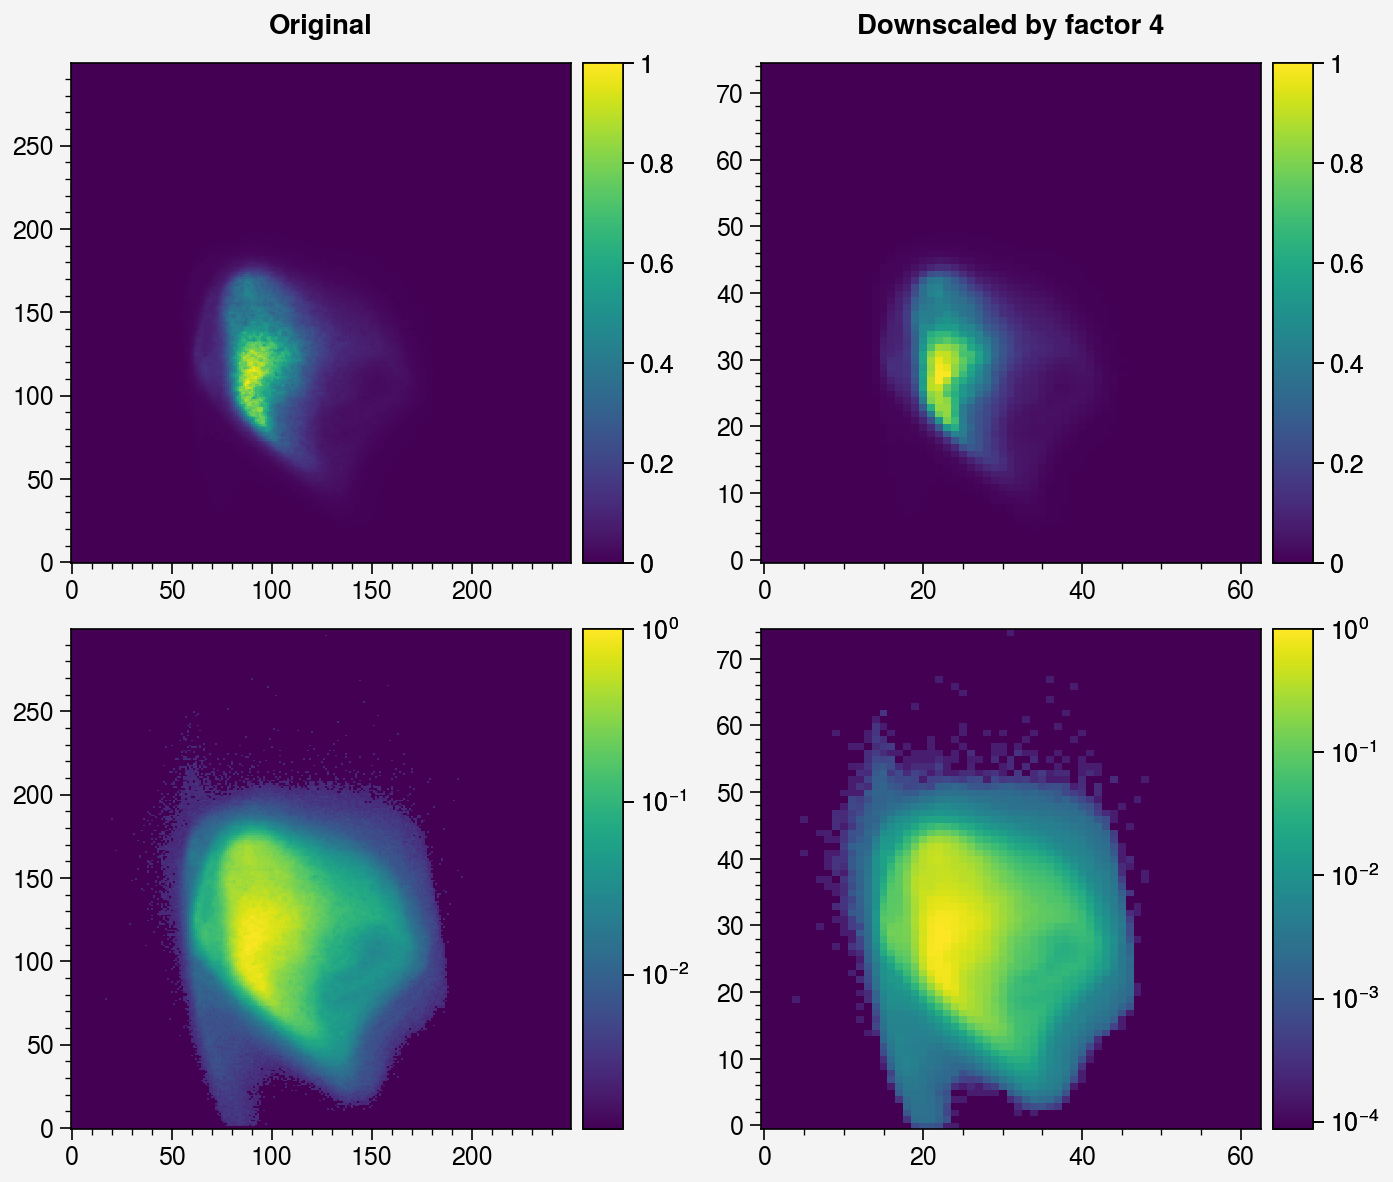

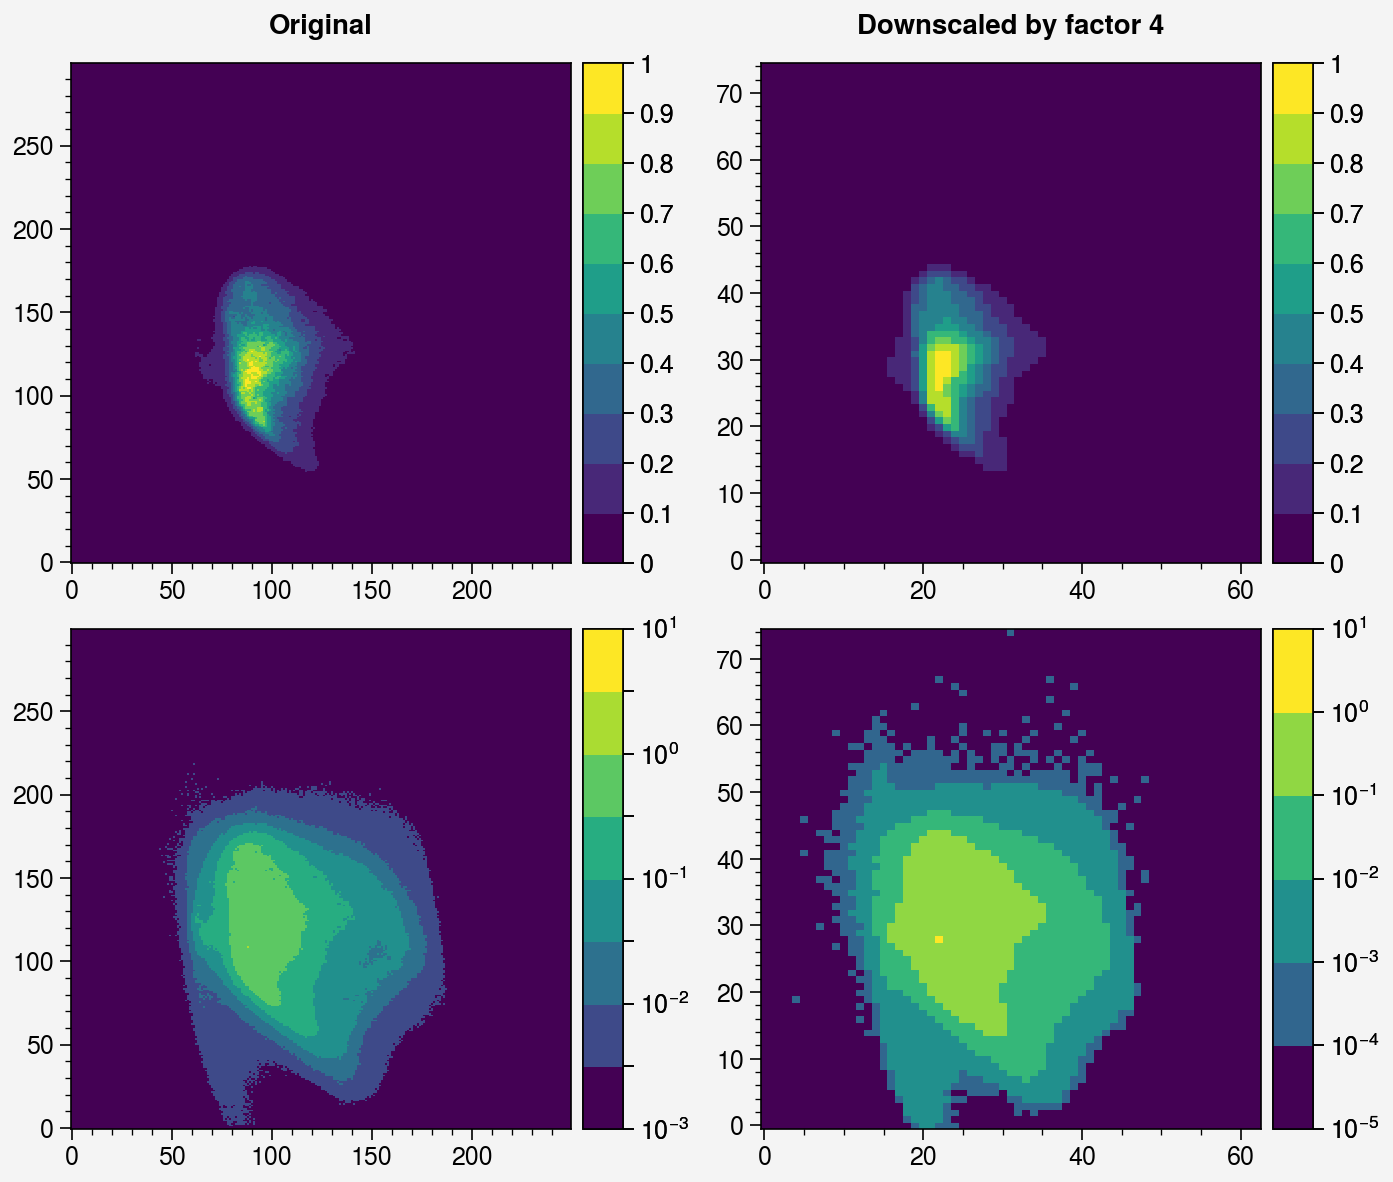

In [36]:
downscale_factor = 4
info['image_downscale'] = downscale_factor
    
im1 = skimage.transform.downscale_local_mean(
    im,
    (downscale_factor, downscale_factor),
)

for discrete in [False, True]:
    axes = plot_compare_images(im / np.max(im), im1 / np.max(im1), colorbar=True, discrete=discrete,
                               handle_log='floor')
    axes.format(toplabels=['Original', f'Downscaled by factor {downscale_factor}'])
    plt.savefig(f'_output/downscale_discrete{discrete}.png')

In [37]:
def update(i, log, downscale, handle_log):
    _im = get_image(i)
    _im = ip.crop(_im, **image_crop_edges)
    _im = _im - image_offset
    _im[_im <= thresh] = 0
    _im = skimage.transform.downscale_local_mean(
        _im,
        (downscale, downscale),
    )
    norm = 'log' if log else None
    fig, ax = pplt.subplots()
    mplt.plot_image(_im.T, ax=ax, colorbar=True, norm=norm, handle_log=handle_log)
    plt.show()
    
interactive(update, i=(imax-50, imax+50), log=True, downscale=(1, 5), handle_log=['floor', 'mask'])

interactive(children=(IntSlider(value=31474, description='i', max=31524, min=31424), Checkbox(value=True, desc…

Downscaling changes pixel/mm.

In [38]:
info['cam_pix2mm_y'] = cam_settings.pix2mm * im.shape[0] / im1.shape[0]
info['cam_pix2mm_x'] = cam_settings.pix2mm * im.shape[1] / im1.shape[1]
print('Original image shape:', im.shape)
print('Downscaled image shape:', im1.shape)
print(f'Original pix2mm_x = pix2mm_y = {cam_settings.pix2mm}')
print('new pix2mm_y =', info['cam_pix2mm_y'])
print('new pix2mm_x =', info['cam_pix2mm_x'])

Original image shape: (300, 250)
Downscaled image shape: (75, 63)
Original pix2mm_x = pix2mm_y = 0.1
new pix2mm_y = 0.4
new pix2mm_x = 0.3968253968253968


Save new image shape.

In [39]:
info['image_shape'] = im1.shape

In [40]:
def process_image(im):
    im = ip.crop(im, **image_crop_edges)
    im = im - image_offset
    im[im <= thresh] = 0
    if downscale_factor > 1:
        im = skimage.transform.downscale_local_mean(
            im, (downscale_factor, downscale_factor),
        )
    return im

## Write new h5 file

Pass info to future notebooks. 

In [41]:
pprint(info)

{'M': array([[1. , 0. , 0. ],
       [0. , 1. , 1.9],
       [0. , 0. , 1. ]]),
 'acts': ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync'],
 'cam': 'cam34',
 'cam_pix2mm_x': 0.3968253968253968,
 'cam_pix2mm_y': 0.4,
 'cam_shape': (512, 612),
 'cam_zoom': 0.5,
 'datadir': '/Diagnostics/Data/Measurements/scan-xxpy-image-ypdE/2022-04-29',
 'filename': '220429190854-scan-xxpy-image-ypdE',
 'image_crop_edges': {'x1': 200, 'x2': 450, 'y1': 135, 'y2': 435},
 'image_downscale': 4,
 'image_offset': 28.0,
 'image_shape': (75, 63),
 'image_thresh': 98.0,
 'ndim': 3,
 'variables': {'x1': {'center': 21.0,
                      'distance': 17.5,
                      'max': 50.0,
                      'min': -50.0,
                      'pvname': 'ITSF_Diag:Slit_VT34a',
                      'steps': 32},
               'x2': {'center': 15.0,
                      'distance': 24.0,
                      'max': 50.0,
                      'min': -50.0,
                      'pvname': 'ITSF_Diag

In [42]:
# Save as pickled dictionary for easy loading.
utils.save_pickle('_output/info.pkl', info)

# Also save as file for viewing.
file = open('_output/info.txt', 'w')
for key, value in info.items():
    file.write(f'{key}: {value}\n')
file.close()

Create a new h5 file with three data sets: scalar (0d), waveform (1d), and image (2d). First, collect the appropriate dtypes.

In [43]:
im = im1.copy()
attrs = data.dtype.names
sc_dtype, sc_attrs = [], list(attrs)
print(sc_attrs)
wf_dtype, wf_attrs = [], []
im_dtype, im_attrs = [], []
print('Moving the following columns:')
for i in reversed(range(len(attrs))):
    attr = attrs[i]
    if '_Image' in attr:
        sc_attrs.pop(i)
        im_attrs.append(attr)
        im_dtype.append((attr, data.dtype[attr]))
        print(attr)
    elif 'Profile' in attr:
        sc_attrs.pop(i)
        wf_attrs.append(attr)
        wf_dtype.append((attr, data.dtype[attr]))
        print(attr)
    else:
        sc_dtype.append((attr, data.dtype[attr]))
        
sc_dtype = np.dtype(sc_dtype)
wf_dtype = np.dtype(wf_dtype)
im_dtype = np.dtype(im_dtype)

# Override the image dtype. 
im_dtype = np.dtype([(cam + '_Image', str(im.dtype), (im.size,))])

print('\nscalars:')
print(sc_dtype)
print('\nwaveforms:')
print(wf_dtype)
print('\nimage:')
print(im_dtype)

['timestamp', 'iteration', 'cam34_Image', 'cam34_ProfileY', 'cam34_ProfileX', 'cam34_Saturation', 'cam34_Integral', 'bcm04', 'y_PositionSync', 'xp_PositionSync', 'x_PositionSync']
Moving the following columns:
cam34_ProfileX
cam34_ProfileY
cam34_Image

scalars:
[('x_PositionSync', '<f8'), ('xp_PositionSync', '<f8'), ('y_PositionSync', '<f8'), ('bcm04', '<f8'), ('cam34_Integral', '<f8'), ('cam34_Saturation', '<f8'), ('iteration', '<i8'), ('timestamp', '<f8')]

waveforms:
[('cam34_ProfileX', '<f4', (612,)), ('cam34_ProfileY', '<f4', (512,))]

image:
[('cam34_Image', '<f8', (4725,))]


Skip points with low BCM current (see above).

In [44]:
n_valid = len(idx_valid)
for i in idx_mask:
    print(f'Ignoring point {i} due to {bcm} current < {bcm_limit} [mA]')
print(f'Number of valid points: {n_valid}')

Ignoring point 41812 due to bcm04 current < 20.0 [mA]
Ignoring point 41813 due to bcm04 current < 20.0 [mA]
Number of valid points: 46144


In [45]:
writer = h5py.File(join(datadir, 'preproc-' + filename + '.h5'), 'w')
data_sc = writer.create_dataset('scalardata', (n_valid,), dtype=sc_dtype)
if len(wf_dtype) > 0:
    data_wf = writer.create_dataset('wfdata', (n_valid,), dtype=wf_dtype)
data_im = writer.create_dataset('imagedata', (n_valid,), dtype=im_dtype)
for i, j in enumerate(tqdm(idx_valid)):
    for attr in sc_attrs:
        data_sc[i, attr] = data[j, attr]
    if len(wf_dtype) > 0:
        for attr in wf_attrs:
            data_wf[i, attr] = data[j, attr]
    for attr in im_attrs:
        data_im[i, attr] = process_image(get_image(i)).ravel()
writer.close()

  0%|          | 0/46144 [00:00<?, ?it/s]